In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from xgboost import XGBClassifier, XGBRegressor

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, PowerTransformer

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import scipy.stats as ss
from collections import Counter

import imblearn
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score, classification_report

In [2]:
df_original = pd.read_csv('Train.csv')
df_original.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [3]:
df = df_original.copy()
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


In [4]:
def cramers(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1) * (r-2)) / (n-1))
    rcorr = r - ((r-1) ** 2)/(n-1)
    kcorr = k - ((k-1) ** 2)/(n-1)
    return np.sqrt(phi2corr/ min((kcorr -1), (rcorr-1)))

In [5]:
y_col = ['Cost_of_the_Product', 'Prior_purchases', 'Weight_in_gms', 'Discount_offered', 'Customer_care_calls' , 'Warehouse_block', 'Mode_of_Shipment', 'Product_importance', 'Customer_rating', 'Gender']
for i in range(len(y_col)):
    cor_res = cramers(df_original['Reached.on.Time_Y.N'], df_original[y_col[i]])
    
    print('{}: {}'.format(y_col[i], round((cor_res * 100), 2)))

Cost_of_the_Product: 15.63
Prior_purchases: 10.7
Weight_in_gms: 66.26
Discount_offered: 46.34
Customer_care_calls: 7.02
Warehouse_block: 1.0
Mode_of_Shipment: 0.82
Product_importance: 3.33
Customer_rating: 1.71
Gender: 0.45


In [6]:
# Weight_in_gms: 66.26
# Discount_offered: 46.34
# Cost_of_the_Product: 15.63
# Prior_purchases: 10.7
# Customer_care_calls: 7.02
# Product_importance: 3.33
# Customer_rating: 1.71
# Warehouse_block: 1.0
# Mode_of_Shipment: 0.82
# Gender: 0.45

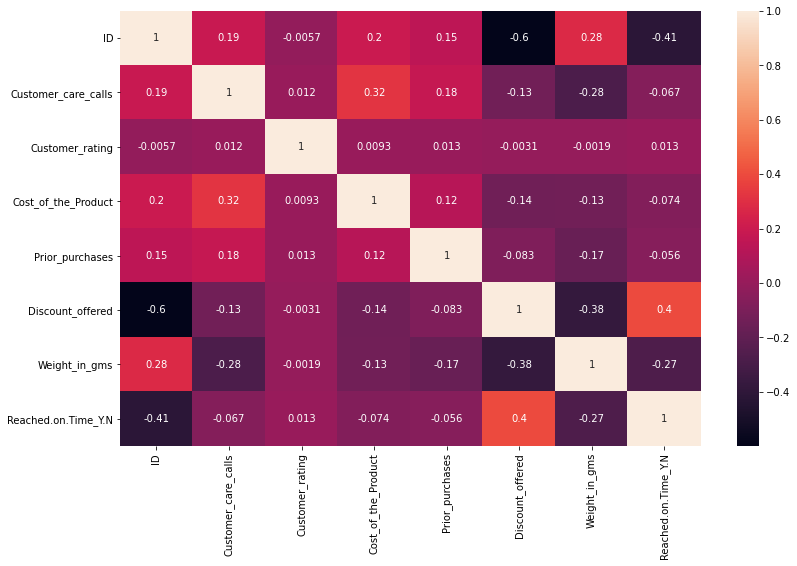

In [7]:
plt.figure(figsize=(13,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

### Choose only relateable features for base

In [8]:
df_base_fs = df[['Weight_in_gms', 'Discount_offered', 'Cost_of_the_Product', 'Prior_purchases', 'Reached.on.Time_Y.N']]
df_base_fs.head()

,Weight_in_gms,Discount_offered,Cost_of_the_Product,Prior_purchases,Reached.on.Time_Y.N
0,1233,44,177,3,1
1,3088,59,216,2,1
2,3374,48,183,4,1
3,1177,10,176,4,1
4,2484,46,184,3,1


In [9]:
def Eva_Matrix2(Model, X_train, y_train, X_test, y_test, name):
    y_pred_train = Model.predict(X_train)
    y_pred_test = Model.predict(X_test)
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    rec_train = recall_score(y_train, y_pred_train)
    rec_test = recall_score(y_test, y_pred_test)
    prec_train = precision_score(y_train, y_pred_train)
    prec_test = precision_score(y_test, y_pred_test)
        
    data = {
        f"Training {name}": [acc_train, rec_train, prec_train],
        f"Testing {name}": [acc_test, rec_test, prec_test]
    }
    
    df_eva = pd.DataFrame(data, index=['Accuracy', 'Recall', 'Precision'])
    return df_eva

### Start Train - Test Base

In [10]:
X = df_base_fs.drop(columns='Reached.on.Time_Y.N')
y = df_base_fs['Reached.on.Time_Y.N']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .20, random_state = 14)

In [12]:
LR_Base = LogisticRegression().fit(X_train, y_train)

In [13]:
KNN_Base = KNeighborsClassifier().fit(X_train, y_train)

In [14]:
SVM_Base = SVC().fit(X_train, y_train)

In [15]:
DT_Base = DecisionTreeClassifier().fit(X_train, y_train)

In [16]:
RF_Base = RandomForestClassifier().fit(X_train, y_train)

In [17]:
XGB_Base = XGBClassifier().fit(X_train, y_train)

[11:12:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [18]:
eva_lr_base = Eva_Matrix2(LR_Base, X_train,  y_train, X_test, y_test, "base new")
eva_lr_base

,Training base new,Testing base new
Accuracy,0.634163,0.644091
Recall,0.676190,0.679360
Precision,0.700335,0.711324


In [19]:
eva_knn_base = Eva_Matrix2(KNN_Base, X_train,  y_train, X_test, y_test, "base new")
eva_knn_base

,Training base new,Testing base new
Accuracy,0.778498,0.657727
Recall,0.780762,0.674029
Precision,0.837043,0.731405


In [20]:
eva_svm_base = Eva_Matrix2(SVM_Base, X_train,  y_train, X_test, y_test, "base new")
eva_svm_base

,Training base new,Testing base new
Accuracy,0.660302,0.674545
Recall,0.689524,0.687738
Precision,0.727054,0.746898


In [21]:
eva_dt_base = Eva_Matrix2(DT_Base, X_train,  y_train, X_test, y_test, "base new")
eva_dt_base

,Training base new,Testing base new
Accuracy,0.999886,0.631818
Recall,0.999810,0.686976
Precision,1.000000,0.693313


In [22]:
eva_rf_base = Eva_Matrix2(RF_Base, X_train,  y_train, X_test, y_test, "base new")
eva_rf_base

,Training base new,Testing base new
Accuracy,0.999886,0.640909
Recall,1.000000,0.653465
Precision,0.999810,0.719195


In [23]:
eva_xgb_base = Eva_Matrix2(XGB_Base, X_train,  y_train, X_test, y_test, "base new")
eva_xgb_base

,Training base new,Testing base new
Accuracy,0.872713,0.647273
Recall,0.840381,0.631379
Precision,0.939923,0.739518


SVC was quite good, LR too, XGB quite overfit not like RF and DT whose too much. KNN meh.

### Use Pipeline for Poly and Scaling

This step might be so itterative, so the result that will be shown is the best result from many itteratives

i'll write down the combination that i might do:
1. poly degree 2 (not good)
2. poly degree 3 (not good)
3. scaling standard (not good)
4. scaling robust (not good)
5. scaling standard with poly degree 2 (not good)
6. scaling standard with poly degree 3 (LR become balance but in 67% while SVM is decreasing 1%)
7. scaling robust with poly degree 2 (not good)
8. scaling robust with poly degree 3 (not good)

In [24]:
num_columns = ['Cost_of_the_Product', 'Prior_purchases', 'Weight_in_gms', 'Discount_offered'] # 

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=3, include_bias=False)),
#     ('power', PowerTransformer(method='yeo-johnson'))
])
preprocessor = ColumnTransformer([
    ('numeric', numeric_pipeline, num_columns)
])

pipe_LR = Pipeline([
    ("prep", preprocessor),
    ("algo", LogisticRegression())
])

pipe_KNN = Pipeline([
    ("prep", preprocessor),
    ("algo", KNeighborsClassifier())
])

pipe_SVM = Pipeline([
    ("prep", preprocessor),
    ("algo", SVC(probability=True))
])

pipe_DT = Pipeline([
    ("prep", preprocessor),
    ("algo", DecisionTreeClassifier())
])

pipe_RF = Pipeline([
    ("prep", preprocessor),
    ("algo", RandomForestClassifier())
])

pipe_XGB = Pipeline([
    ("prep", preprocessor),
    ("algo", XGBClassifier())
])

In [25]:
X = df_base_fs.drop(columns='Reached.on.Time_Y.N')
y = df_base_fs['Reached.on.Time_Y.N']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = .20, random_state = 14)

In [27]:
pipe_LR.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Weight_in_gms',
                                                   'Discount_offered'])])),
                ('a

In [28]:
pipe_KNN.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Weight_in_gms',
                                                   'Discount_offered'])])),
                ('a

In [29]:
pipe_SVM.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Weight_in_gms',
                                                   'Discount_offered'])])),
                ('a

In [30]:
pipe_DT.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Weight_in_gms',
                                                   'Discount_offered'])])),
                ('a

In [31]:
pipe_RF.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Weight_in_gms',
                                                   'Discount_offered'])])),
                ('a

In [32]:
pipe_XGB.fit(X_train, y_train)

[11:14:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=3,
                                                                                      include_bias=False))]),
                                                  ['Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Weight_in_gms',
                                                   'Discount_offered'])])),
                ('a

In [33]:
eva_lr_pipe = Eva_Matrix2(pipe_LR, X_train,  y_train, X_test, y_test, "pipe")
eva_lr_pipe

,Training pipe,Testing pipe
Accuracy,0.673940,0.672273
Recall,0.607048,0.602437
Precision,0.798147,0.798990


In [34]:
eva_knn_pipe = Eva_Matrix2(pipe_KNN, X_train,  y_train, X_test, y_test, "pipe")
eva_knn_pipe

,Training pipe,Testing pipe
Accuracy,0.784976,0.635909
Recall,0.793905,0.655750
Precision,0.837284,0.711570


In [35]:
eva_svm_pipe = Eva_Matrix2(pipe_SVM, X_train,  y_train, X_test, y_test, "pipe")
eva_svm_pipe

,Training pipe,Testing pipe
Accuracy,0.686555,0.662273
Recall,0.543810,0.519421
Precision,0.887197,0.858942


In [36]:
eva_dt_pipe = Eva_Matrix2(pipe_DT, X_train,  y_train, X_test, y_test, "pipe")
eva_dt_pipe

,Training pipe,Testing pipe
Accuracy,0.999886,0.646364
Recall,0.999810,0.715918
Precision,1.000000,0.698885


In [37]:
eva_rf_pipe = Eva_Matrix2(pipe_RF, X_train,  y_train, X_test, y_test, "pipe")
eva_rf_pipe

,Training pipe,Testing pipe
Accuracy,0.999886,0.635455
Recall,0.999810,0.654227
Precision,1.000000,0.711682


In [38]:
eva_xgb_pipe = Eva_Matrix2(pipe_XGB, X_train,  y_train, X_test, y_test, "pipe")
eva_xgb_pipe

,Training pipe,Testing pipe
Accuracy,0.942493,0.649091
Recall,0.926095,0.651181
Precision,0.976305,0.731394


So, the best result so far for our models are :
1. Base Model from SVM
2. Base scaling standard with poly degree 3 (LR become balance but in 67% while SVM is decreasing 1%)

Okay now, lets try Fine tunning in Base scaling standard with poly degree 3

### Do Fine Tunning

In [163]:
param_svm = {'C' : np.linspace(0.00001, 10, 1000),
             'kernel' : ['linear', 'rbf'],
             "gamma" : np.arange(0.0001, 100)}

In [43]:
skf= StratifiedKFold(n_splits=3)

In [169]:
svm_base_tune = RandomizedSearchCV(SVM_Base, param_svm, cv = 3, n_jobs = -1 , n_iter=500, verbose = 1, scoring = 'accuracy').fit(X_train, y_train)

Fitting 3 folds for each of 500 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 113.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 238.3min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 430.4min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 704.9min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed: 850.3min finished


In [170]:
svm_base_tune.best_estimator_

SVC(C=9.16917, gamma=0.0001)

In [171]:
SVM_Tuned_1 = svm_base_tune.best_estimator_

In [172]:
eva_svm_pipe_tune = Eva_Matrix2(SVM_Tuned_1, X_train,  y_train, X_test, y_test, "tune")
eva_svm_pipe_tune

,Training tune,Testing tune
Accuracy,0.698829,0.667727
Recall,0.562286,0.518660
Precision,0.893462,0.873077


In [79]:
# param_rf = {
#     'n_estimators' : [100, 200],
#     'max_depth' : [None, 25, 50, 75],
#     'min_samples_leaf' : [20],
#     'min_samples_split' : [20, 40],
# }
param_rf = {
    'n_estimators' : [200, 400, 600, 800],
    'max_depth' : [None, 10, 20, 30, 40, 50],
    'min_samples_leaf' : [1, 2, 4],
    'min_samples_split' : [2, 5, 10],
    'max_features': ['auto', 'sqrt'],
}

In [80]:
rf_base_tune = RandomizedSearchCV(RF_Base, param_rf, cv =skf, n_jobs = -1 , n_iter=300, verbose = 1, scoring = 'accuracy').fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 16.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 30.9min finished


In [81]:
rf_base_tune.best_estimator_

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_split=5,
                       n_estimators=400)

In [82]:
RF_Tuned_1 = rf_base_tune.best_estimator_

In [83]:
eva_rf_pipe_tune = Eva_Matrix2(RF_Tuned_1, X_train,  y_train, X_test, y_test, "tune")
eva_rf_pipe_tune

,Training tune,Testing tune
Accuracy,0.767587,0.670000
Recall,0.624571,0.526276
Precision,0.977930,0.869182


Wow, quite good tuning for Random Forest. The train accuracies is decreasing and the testing acc is increasing too but not too much, may be we change the param.

In [50]:
sc = StandardScaler()

In [51]:
num_col = df[['Cost_of_the_Product', 'Prior_purchases', 'Weight_in_gms', 'Discount_offered']]

In [52]:
sc_train = sc.fit_transform(num_col)

In [54]:
data_sc = pd.DataFrame(sc_train)

In [55]:
data_sc.head()

,0,1,2,3
0,-0.690722,-0.372735,-1.468240,1.889983
1,0.120746,-1.029424,-0.333893,2.815636
2,-0.565881,0.283954,-0.159002,2.136824
3,-0.711529,0.283954,-1.502484,-0.208162
4,-0.545074,-0.372735,-0.703244,2.013404


In [56]:
df_scaled = pd.concat([df_base_fs, data_sc], axis=1)

In [58]:
df_scaled.drop(columns=['Cost_of_the_Product', 'Prior_purchases', 'Weight_in_gms', 'Discount_offered'], inplace=True)

In [59]:
X_scaled = df_scaled.drop(columns='Reached.on.Time_Y.N')
y_scaled = df_scaled['Reached.on.Time_Y.N']

In [60]:
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_scaled, y_scaled, stratify = y_scaled, test_size= .20, random_state = 14)

In [61]:
LR_Base_scaled = LogisticRegression().fit(X_train_sc, y_train_sc)

In [62]:
SVM_Base_scaled = SVC().fit(X_train_sc, y_train_sc)

In [71]:
RF_Base_scaled = RandomForestClassifier().fit(X_train_sc, y_train_sc)

In [64]:
eva_lr_sc = Eva_Matrix2(LR_Base_scaled, X_train_sc,  y_train_sc, X_test_sc, y_test_sc, "scale")
eva_lr_sc

,Training scale,Testing scale
Accuracy,0.634163,0.644545
Recall,0.676190,0.680122
Precision,0.700335,0.711554


In [65]:
eva_svc_sc = Eva_Matrix2(SVM_Base_scaled, X_train_sc,  y_train_sc, X_test_sc, y_test_sc, "scale")
eva_svc_sc

,Training scale,Testing scale
Accuracy,0.685305,0.667727
Recall,0.506286,0.483625
Precision,0.937566,0.922965


In [72]:
eva_rf_sc = Eva_Matrix2(RF_Base_scaled, X_train_sc,  y_train_sc, X_test_sc, y_test_sc, "scale")
eva_rf_sc

,Training scale,Testing scale
Accuracy,0.999886,0.641818
Recall,0.999810,0.659558
Precision,1.000000,0.717481


In [84]:
rf_base_tune2 = RandomizedSearchCV(RF_Base_scaled, param_rf, cv =skf, n_jobs = -1 , n_iter=300, verbose = 1, scoring = 'accuracy').fit(X_train_sc, y_train_sc)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 27.8min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 31.3min finished


In [85]:
RF_Tuned_2 = rf_base_tune2.best_estimator_

In [86]:
eva_svm_pipe_tune = Eva_Matrix2(RF_Tuned_2, X_train_sc,  y_train_sc, X_test_sc, y_test_sc, "tune")
eva_svm_pipe_tune

,Training tune,Testing tune
Accuracy,0.772815,0.667273
Recall,0.632571,0.524752
Precision,0.979357,0.864492


In [87]:
pipe_LR.get_params()

{'memory': None,
 'steps': [('prep', ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('imputer', SimpleImputer()),
                                                    ('scaler', StandardScaler()),
                                                    ('poly',
                                                     PolynomialFeatures(degree=3,
                                                                        include_bias=False))]),
                                    ['Cost_of_the_Product', 'Prior_purchases',
                                     'Weight_in_gms', 'Discount_offered'])])),
  ('algo', LogisticRegression())],
 'verbose': False,
 'prep': ColumnTransformer(transformers=[('numeric',
                                  Pipeline(steps=[('imputer', SimpleImputer()),
                                                  ('scaler', StandardScaler()),
                                                  ('poly',
                                

In [93]:
param_lr = {
    'algo__penalty' : ['l1', 'l2'],
    'algo__C' : np.logspace(-4, 4, 20)
}

In [94]:
lr_base_tune2 = RandomizedSearchCV(pipe_LR, param_lr, cv =skf, n_jobs = -1 , n_iter=300, verbose = 1, scoring = 'accuracy').fit(X_train, y_train)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    4.6s finished


In [95]:
LR_Tuned_2 = lr_base_tune2.best_estimator_

In [96]:
eva_svm_pipe_tune = Eva_Matrix2(LR_Tuned_2, X_train,  y_train, X_test, y_test, "tune")
eva_svm_pipe_tune

,Training tune,Testing tune
Accuracy,0.671781,0.672273
Recall,0.612762,0.610053
Precision,0.790029,0.793069


In [101]:
param_knn = {
    'algo__n_neighbors' : np.arange(1, 31, 2),
    'algo__p' : [1, 2],
    'algo__weights' : ['uniform', 'distance']
}

In [102]:
knn_base_tune2 = RandomizedSearchCV(pipe_KNN, param_knn, cv =skf, n_jobs = -1 , n_iter=300, verbose = 1, scoring = 'accuracy').fit(X_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:   42.9s finished


In [103]:
KNN_Tuned_2 = knn_base_tune2.best_estimator_

In [104]:
eva_knn_pipe_tune = Eva_Matrix2(KNN_Tuned_2, X_train,  y_train, X_test, y_test, "tune")
eva_knn_pipe_tune

,Training tune,Testing tune
Accuracy,0.999886,0.650909
Recall,0.999810,0.627570
Precision,1.000000,0.747053


-------------------------------------------------------------------------------------------------------------------------------

So we've tried some combinations of modeling by using pipeline or with a standard way, but the results is not getting better from the base result. So, we've conclude that this might be because of the data itself wether the data has no pattern or two. 

Since our data is Balance, what we see is the Accuracy result. And the best result of our modeling is by using scaling with StandardScaler and PolynomialFeatures with degrees number is 3. Here's the best result:

In [39]:
eva_lr_pipe

,Training pipe,Testing pipe
Accuracy,0.673940,0.672273
Recall,0.607048,0.602437
Precision,0.798147,0.798990


The percentage of accuracy in Train and Test are 67%. This the best thing we can get so far.

So by using our model (Logistic Regression) we can predict wether the item will arrive on time to the customer around 67% of success.